# Linear Programming: DMC Formulation (Simplified)
- Author: Siang Lim, March 2nd 2022

## References
- Morshedi, A. M., Cutler, C. R., & Skrovanek, T. A. (1985). Optimal solution of dynamic matrix control with linear programing techniques (LDMC). In 1985 American Control Conference (pp. 199-208). IEEE.
- Sorensen, R. C., & Cutler, C. R. (1998). LP integrates economics into dynamic matrix control. Hydrocarbon Processing, 77(9), 57-65.
- Ranade, S. M., & Torres, E. (2009). From dynamic mysterious control to dynamic manageable control. Hydrocarbon Processing, 88(3), 77-81.
- Godoy, J. L., Ferramosca, A., & González, A. H. (2017). Economic performance assessment and monitoring in LP-DMC type controller applications. Journal of Process Control, 57, 26-37.

# 1. DMC Overview

DMC (Dynamic Matrix Control) belongs to a family of controllers known as 'Model Predictive Control' (MPC).

> **Note:**
One important point here is that DMC-type MPCs in the process industry are implemented with an integrated steady-state optimizer (usually LP) that generates SS targets for the MPC algorithm. This is something that's not often clear in academic papers, which usually focuses on the MPC algorithm itself. Another common misconception is that the LP is the same as an RTO layer, this is also not correct. See Godoy (2017).

DMC answers 3 questions about the process and how to control it.

1. **Where am I?** It uses empirical **models** from step tests to **predict** how the process is moving.
2. **Where should I go?**. It uses a steady-state LP optimizer to generate **SS targets** that keep the process at an economic optimum.
3. **How should I get there?** It generates a **move plan** to move the process to the optimum point based on these SS targets.

The LP steady-state (SS) optimizer is responsible for generating SS targets for the move calculations. We will look at this component first, and the Prediction and Move Plan modules in subsequent notebooks.

<div>
<br>
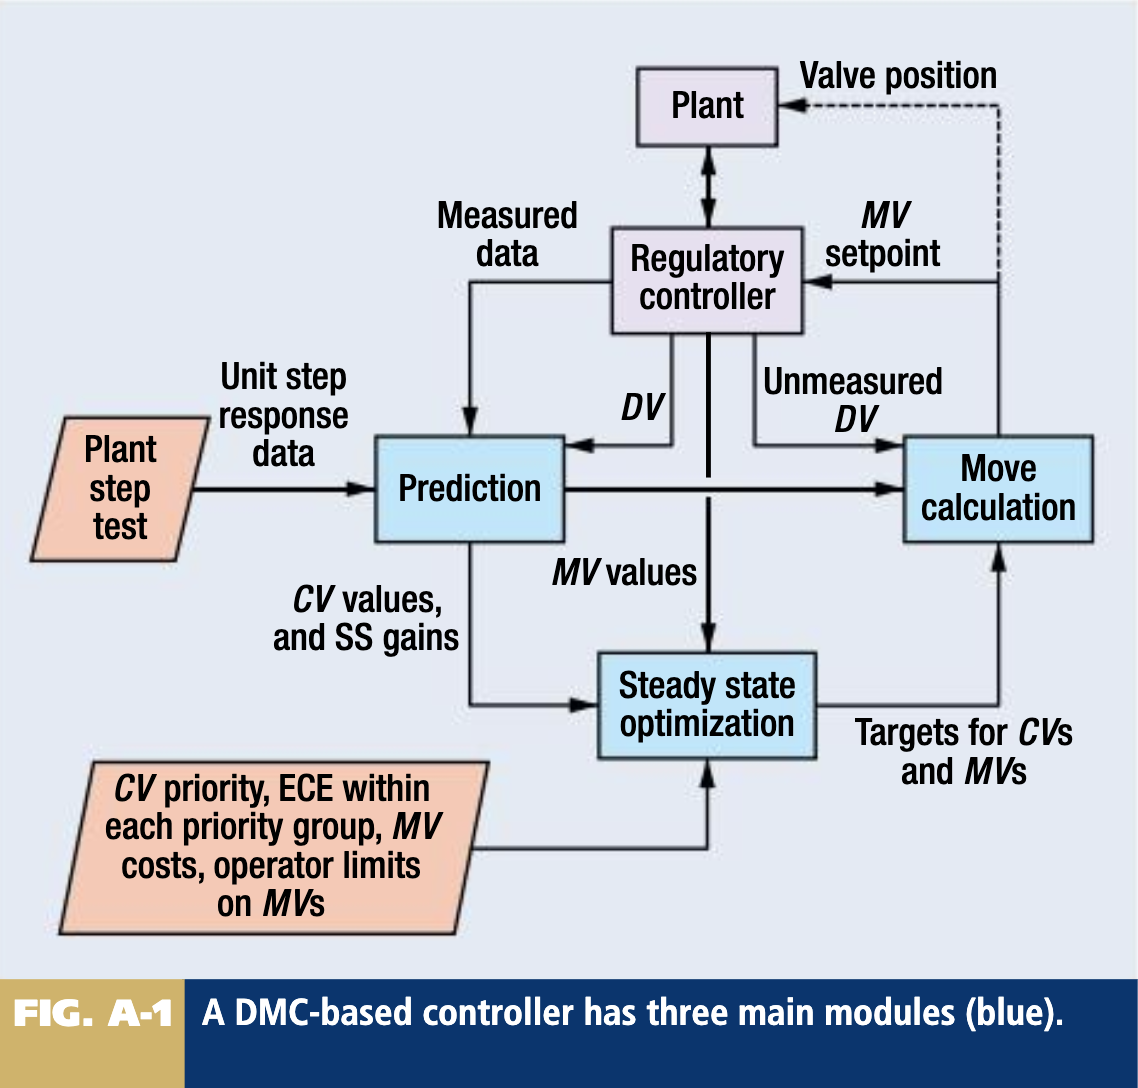
</div>

From: *Ranade, S. M., & Torres, E. (2009). From dynamic mysterious control to dynamic manageable control. Hydrocarbon Processing, 88(3), 77-81.*

$$\require{nicematrix}$$

# 2. The LP steady-state optimizer in DMC

In multivariable controllers, we have Manipulated Variables (MVs) which are handles that can be adjusted to move the process. The effects of moving the MVs are reflected in the Controlled Variable (CVs).

The steady-state relationship between an MV and a CV is captured by its **steady-state process gain**. In multivariable controllers, we have a **gain matrix** that captures the relationships between multiple MVs and CVs.

Consider a $2\times2$ gain matrix, $G$ with 2 MVs and 2 CVs. There will be 4 elements, where each $G_{ij}$ describes the relationship between the $i$-th CV and $j$-th MV.

$$
G =
    \begin{bmatrix}
        G_{11} & G_{12} \\
        G_{21} & G_{22}
    \end{bmatrix}
$$

Note that mathematically, the CVs are rows, and MVs are columns. This is the opposite of the usual convention in commercial MPC software, where the MVs are plotted as rows, and CVs as columns.

<div>
<br>
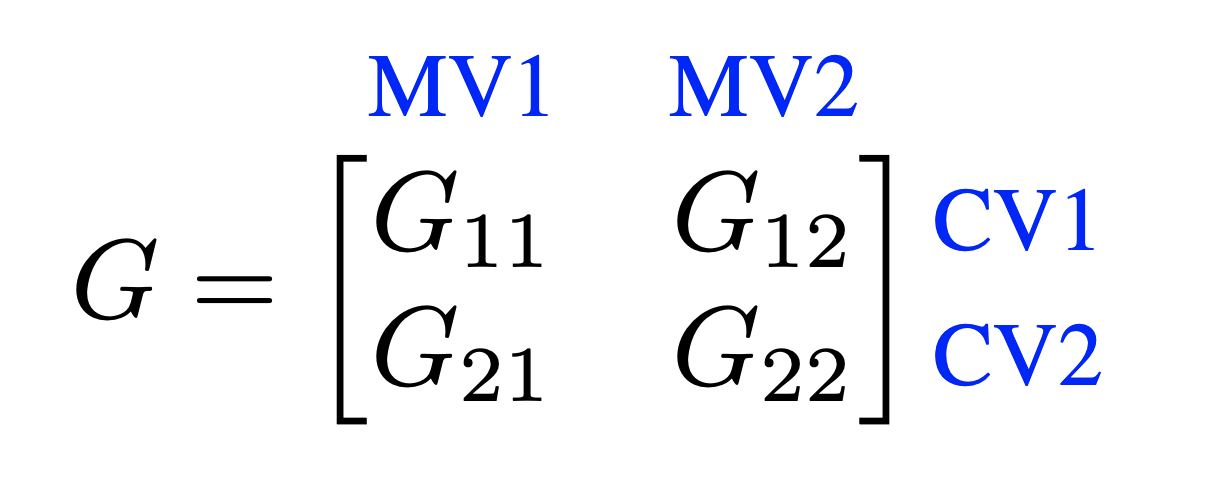
</div>

The equation relating the CVs and MVs through the gain matrix is given by:

$$ \Delta CV = G \cdot \Delta MV $$

Multiplying the terms in the matrix, we get:

$$
\Delta \text{CV}_{1} = G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \\ 
\Delta \text{CV}_{2} = G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} 
$$


##  2.1 The debutanizer process

Let's look at a debutanizer process, which separates C4- molecules at the top of the column from heavier components at the bottom.

<div>
<br>
<img src="attachment:image-2.png" width="600"/>
</div>

To simplify the problem, let's just consider 2 MVs and 2 CVs.

- **MV1:** Reboiler Temperature Control (TC-REBOILER)
- **MV2:** Reflux Flow Rate Control (FC-REFLUX)
- **CV1:** Bottoms RVP (AI-BTM-RVP)
- **CV2:** Overhead C5 Content (AI-TOP-C5)

The gain matrix is given as:
$$
G =
    \begin{bmatrix}
        -0.200 & -0.072 \\
        0.125 & -0.954
    \end{bmatrix}
$$

The gain matrix tells us that:
- Every unit increase in reboiler temperature reduces RVP by 0.20 units and increases C5 by 0.125 units.
- This makes sense, if we fire the reboiler harder, we boil stuff up the top so the bottom RVP decreases (less volatile, more heavier components), and some of the heavier components go up the column, so overhead C5 increases.
- Every unit increase in reflux reduces RVP by 0.072 units and reduces C5 by 0.954 units.
- This also makes sense, because increasing reflux improves separation (up to a certain point, considering flooding limits etc.)

## 2.2 MV-CV equations

Using the gain matrix, the CV relationship can be written in terms of its MVs, starting with:

$$
\Delta \text{CV}_{1} = G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \\ 
\Delta \text{CV}_{2} = G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} 
$$

We can impose upper and lower limits on the MVs:

$$
\text{MV}_{1, \text{Lo}} \leq \text{MV}_{1} \leq \text{MV}_{1, \text{Hi}}\\ 
\text{MV}_{2, \text{Lo}} \leq \text{MV}_{2} \leq \text{MV}_{2, \text{Hi}}\\
$$

As well as the CVs:

$$
\text{CV}_{1, \text{Lo}} \leq \text{CV}_{1} \leq \text{CV}_{1, \text{Hi}}\\ 
\text{CV}_{2, \text{Lo}} \leq \text{CV}_{2} \leq \text{CV}_{2, \text{Hi}}\\
$$

Since the CVs are related to the MVs by the gain matrix, we can substitute the equations to get CV limits in terms of MV movements:

$$
G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \leq \Delta \text{CV}_{1, \text{Hi}}\\
G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \geq \Delta \text{CV}_{1, \text{Lo}}\\
G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} \leq \Delta \text{CV}_{2, \text{Hi}} \\
G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} \geq \Delta \text{CV}_{2, \text{Lo}} \\
$$

Let's see what this looks like:

In [1]:
# Just importing libraries and tweaking the plot settings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# Gains and CV Limits

In [2]:
G11 = -0.200
G12 = -0.072
G21 = 0.125
G22 = -0.954

CV1Lo = -1
CV1Hi = 1

CV2Lo = -2
CV2Hi = 2.5

## 2.3 The Feasible Region

The shaded area below is known as the `feasible region` or `solution space` in the LP problem. It is defined based on the current process conditions and the distance of each variable from its constraints.

<IPython.core.display.Javascript object>


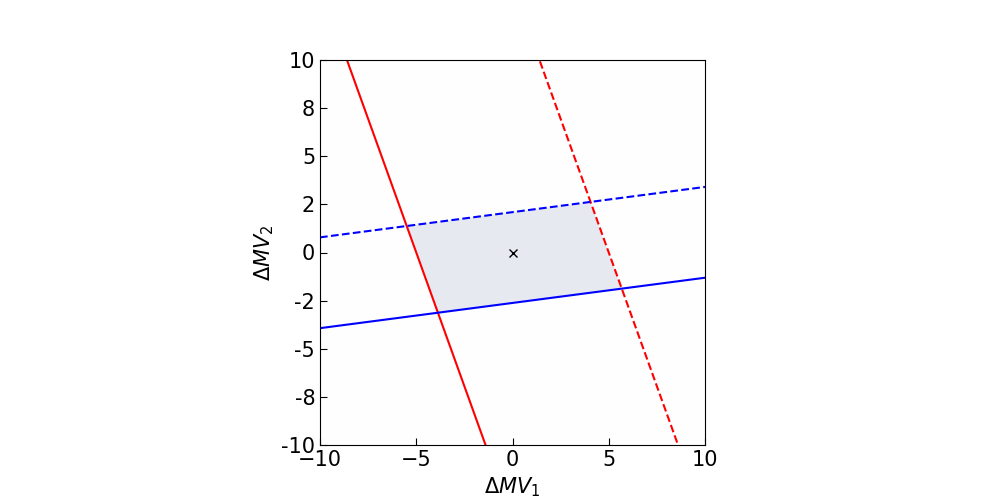

In [3]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');
plt.plot(0,0,'kx');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

## 2.4 The optimum point (LP solution)
The feasible region tells us that the LP optimizer is allowed to move $\Delta MV_1$ and $\Delta MV_2$ within the shaded region to honour the CV limits.

The question now is, out of all the possible points in the feasible region, which one should the optimizer pick and why? Recall in the previous chapter that for the cat food production problem, the objective function is defined as finding combinations of chicken, $x_1$ and beef, $x_2$, given the cost of chicken $c_1$, and cost of beef $c_2$, such that the total production costs are minimized:

$$\min_{x_1, x_2} f(x_1, x_2) = c_1 x_1 + c_2 x_2$$

The objective function in DMC is defined in a similar manner. The equations below are a simplified version of the actual objective function (see Sorensen, R. C., & Cutler, C. R. (1998) for details). We want to assign an 'LP cost' to each MV, based on the economics and desired directionality of MV movement.

For example,

$$\min_{\Delta MV_1, \Delta MV_2} f(\Delta MV_1, \Delta MV_2) = c_1 \Delta MV_1 + c_2 \Delta MV_2$$

As a rule of thumb, a negative LP cost would incentivize the DMC LP to maximize that variable, and likewise, a positive cost would incentivize the DMC LP to minimize that variable. However, there are exceptions as we will see later on.

For now, let's assume that we have the following LP costs:

- $c_1 = -1$
- $c_2 = -1$

In [51]:
cost_MV1 = -1
cost_MV2 = -1

## 3 Set up the LP problem in PuLP

In [125]:
# Import PuLP modeler functions
from pulp import *

In [36]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("DMC_problem",LpMinimize)

In [37]:
# The 2 variables MV1 and MV2 are created with a lower limit of zero
MV1=LpVariable("MV1",-10)
MV2=LpVariable("MV2",-10)

In [38]:
# The objective function is added to 'prob' first
prob += cost_MV1*MV1 + cost_MV2*MV2, "Cost function of MVs"

In [39]:
# constraint formulation in terms of MV1 and MV2
prob += G11*MV1+G12*MV2 <= CV1Hi, "CV1 High Limit"
prob += G11*MV1+G12*MV2 >= CV1Lo, "CV1 Low Limit"
prob += G21*MV1+G22*MV2 <= CV2Hi, "CV2 High Limit"
prob += G21*MV1+G22*MV2 >= CV2Lo, "CV2 Low Limit"

In [40]:
prob

DMC_problem:
MINIMIZE
1*MV1 + -1*MV2 + 0
SUBJECT TO
CV1_High_Limit: - 0.2 MV1 - 0.072 MV2 <= 1

CV1_Low_Limit: - 0.2 MV1 - 0.072 MV2 >= -1

CV2_High_Limit: 0.125 MV1 - 0.954 MV2 <= 2.5

CV2_Low_Limit: 0.125 MV1 - 0.954 MV2 >= -2

VARIABLES
-10 <= MV1 Continuous
-10 <= MV2 Continuous

In [41]:
# The problem is solved using PuLP's choice of Solver
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/datalab/.local/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/e734e13ae5014ef8ac8d5c36af02487a-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/e734e13ae5014ef8ac8d5c36af02487a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 28 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 2 (0) columns and 8 (0) elements
0  Obj 0 Primal inf 14.669182 (2) Dual inf 0.9999999 (1)
0  Obj 0 Primal inf 14.669182 (2) Dual inf 2.2289727e+10 (2)
2  Obj -6.8718719
Optimal - objective value -6.8718719
Optimal objective -6.871871872 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0

1

In [42]:
# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    print(v.name, "=", v.varValue)
    
soln = [v.varValue for v in prob.variables()]

MV1 = -5.4954955
MV2 = 1.3763764


<IPython.core.display.Javascript object>


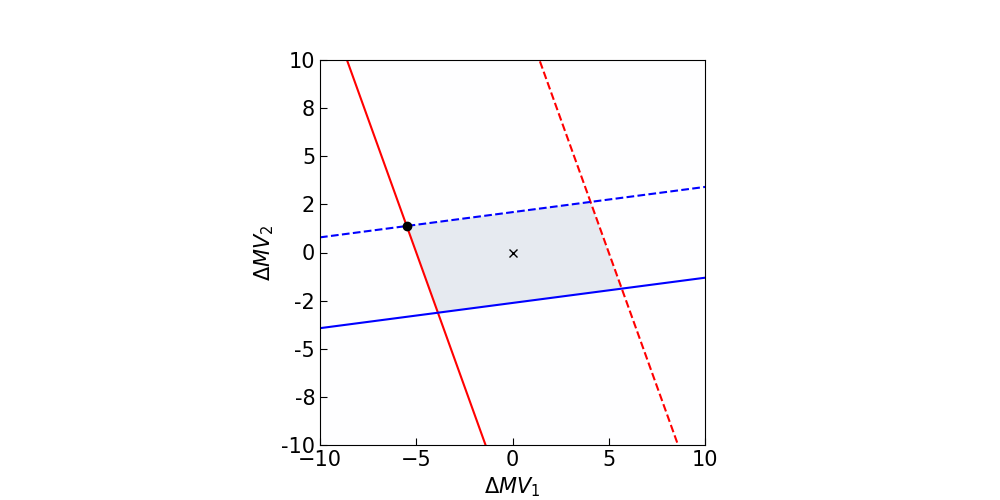

In [43]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');
plt.plot(0,0,'kx');
plt.plot(soln[0], soln[1], 'ok');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

The objective function value, $V$, can be accessed using

In [14]:
value(prob.objective)

-6.6816817

Recall that the objective function is:

$$\min_{\Delta MV_1, \Delta MV_2} f(\Delta MV_1, \Delta MV_2) = c_1 \Delta MV_1 + c_2 \Delta MV_2$$

So our line would be:

$$c_1 x + c_2 y = V$$

Rearrange the equation to get:

$$ y = \frac{1}{c_2} V - \frac{c_1}{c_2} x $$

In [15]:
V = value(prob.objective)

Let's plot the line

<IPython.core.display.Javascript object>


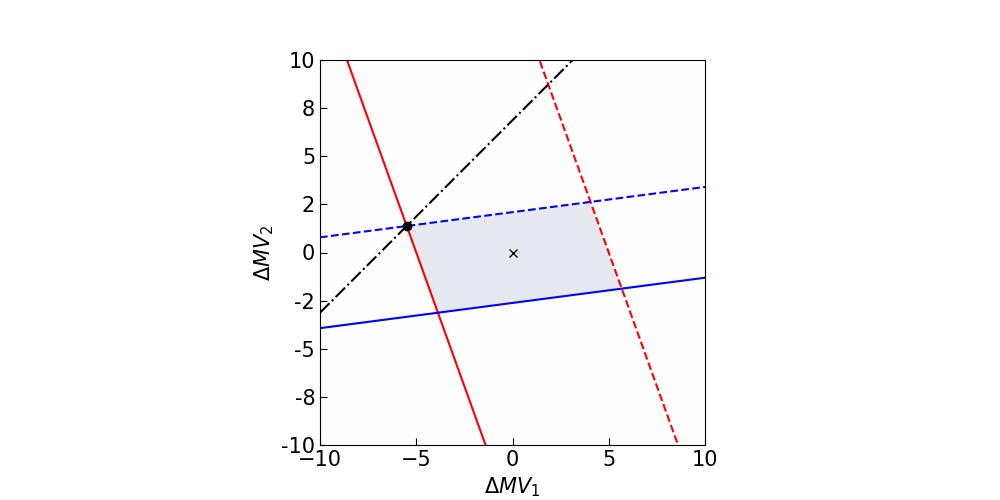

In [50]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

V = value(prob.objective)
y_obj = (1/cost_MV2)*V - (cost_MV1/cost_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

### Save the workflow for running pulp in a separate function

In [118]:
def run_pulp(cost_MV1, cost_MV2, MV1_Lo=-10, MV2_Lo=-10):
    '''
    Run pulp solver for LP problem with the same gain matrix and CV limits as the example. Returns a tuple with:
    (LP solution array [MV1_solution, MV2_solution], objective_value)
    '''
    
    # Gains and CV limits
    G11 = -0.200
    G12 = -0.072
    G21 = 0.125
    G22 = -0.954

    CV1Lo = -1
    CV1Hi = 1

    CV2Lo = -2
    CV2Hi = 2.5

    prob = LpProblem("DMC_2", LpMinimize)
    
    MV1 = LpVariable("MV1", MV1_Lo)
    MV2 = LpVariable("MV2", MV2_Lo)
    
    prob += cost_MV1 * MV1 + cost_MV2 * MV2
    
    # constraint formulation in terms of MV1 and MV2
    prob += G11*MV1+G12*MV2 <= CV1Hi, "CV1 High Limit"
    prob += G11*MV1+G12*MV2 >= CV1Lo, "CV1 Low Limit"
    prob += G21*MV1+G22*MV2 <= CV2Hi, "CV2 High Limit"
    prob += G21*MV1+G22*MV2 >= CV2Lo, "CV2 Low Limit"
    
    # The problem is solved using PuLP's choice of Solver
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Each of the variables is printed with it's resolved optimum value
    for v in prob.variables():
        print(v.name, "=", v.varValue)

    soln = [v.varValue for v in prob.variables()]
    
    obj_value = value(prob.objective)
    
    return (soln, obj_value)

### Changes in the objective function

As mentioned previously, a rule of thumb is that variables with negative LP costs are maximized and vice versa. However, the direction DMC will optimize a variable will be determined by the solution to the objective function.

Recall that the objective function is:

$$\min_{\Delta MV_1, \Delta MV_2} f(\Delta MV_1, \Delta MV_2) = c_1 \Delta MV_1 + c_2 \Delta MV_2$$

Let's see how changing the LP costs will affect the solution. Assume that we changed the costs as follows:

- $c_1 = -1$
- $c_2 = +1$ \(same as before)

MV1 = 5.6756757
MV2 = -1.8768769


<IPython.core.display.Javascript object>


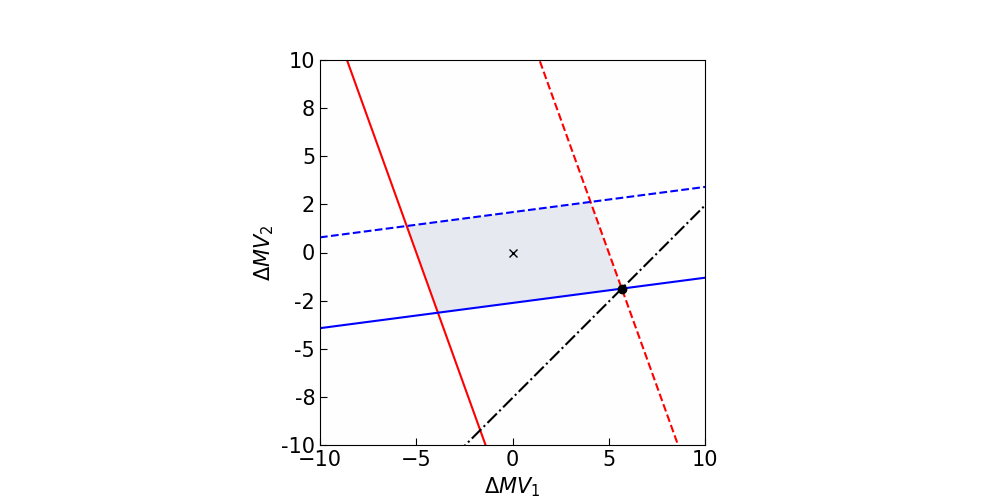

In [119]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

lpc_MV1 = -1
lpc_MV2 = 1

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

soln, V = run_pulp(lpc_MV1, lpc_MV2)
# y_obj = (1/lpc_MV1)*V - (lpc_MV1/lpc_MV2)*d
y_obj = (1/lpc_MV2)*V - (lpc_MV1/lpc_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

Notice that MV2 is now being minimized, while MV1 is still being maximized.

Similarly, if we set $c_1 = +1$ and $c_2 = +1$, we should see that both variables will now be minimized.

MV1 = -3.8738739
MV2 = -3.1281281


<IPython.core.display.Javascript object>


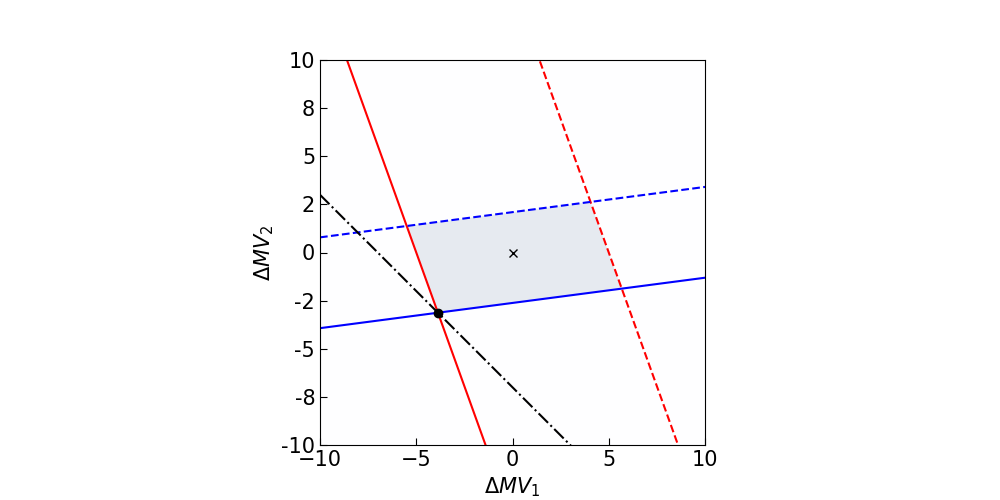

In [120]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

lpc_MV1 = 1
lpc_MV2 = 1

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

soln, V = run_pulp(lpc_MV1, lpc_MV2)
# y_obj = (1/lpc_MV1)*V - (lpc_MV1/lpc_MV2)*d
y_obj = (1/lpc_MV2)*V - (lpc_MV1/lpc_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

#### NOTE
There is a point in each variable's LP cost where its direction of optimization will change, and this depends on where the LP solution lies at any given point.

For example, if we set $c_2 = 0.3$ (i.e. where it is still positive):

MV1 = -5.4954955
MV2 = 1.3763764


<IPython.core.display.Javascript object>


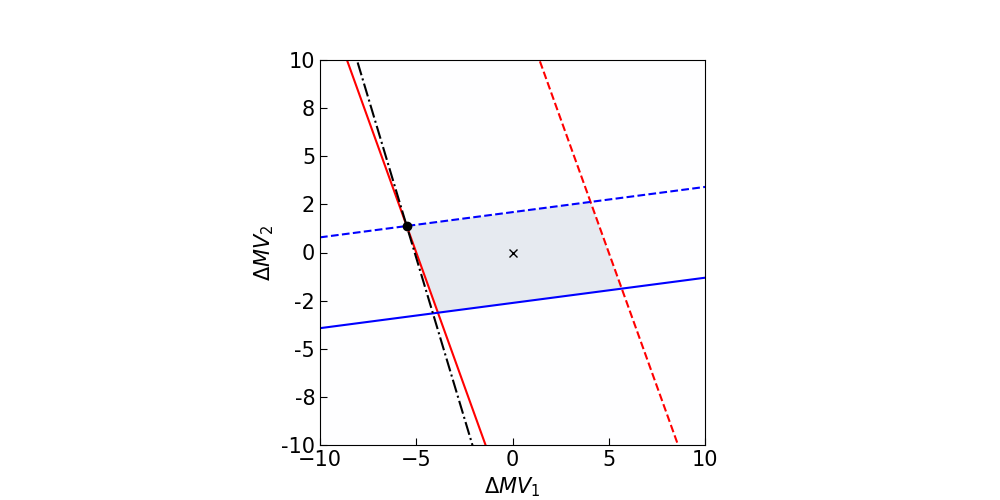

In [121]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

lpc_MV1 = 1
lpc_MV2 = 0.3

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

soln, V = run_pulp(lpc_MV1, lpc_MV2)
# y_obj = (1/lpc_MV1)*V - (lpc_MV1/lpc_MV2)*d
y_obj = (1/lpc_MV2)*V - (lpc_MV1/lpc_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

MV1 = -5.4954955
MV2 = 1.3763764


<IPython.core.display.Javascript object>


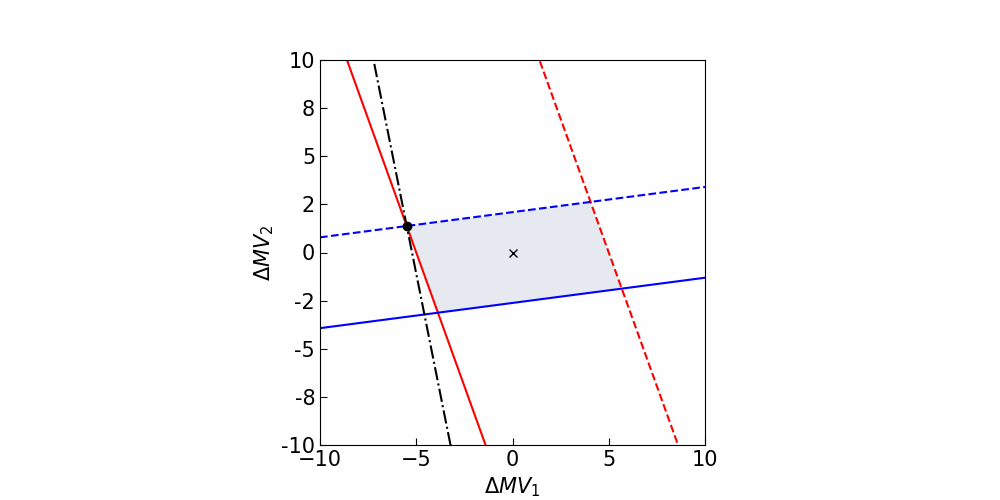

In [122]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

lpc_MV1 = 1
lpc_MV2 = 0.2

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

soln, V = run_pulp(lpc_MV1, lpc_MV2)
# y_obj = (1/lpc_MV1)*V - (lpc_MV1/lpc_MV2)*d
y_obj = (1/lpc_MV2)*V - (lpc_MV1/lpc_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

### Changes in MV limits

All of these examples are assuming that we have constant CV and MV limits. In practice, we use the limits to move the variables around as necessary, so taking variable MV limits into account is an important aspect of the LP solution.

Currently, both variables have limits between $(-10, 10)$. Let us see how the solution changes if we clamp the lower limit of MV1 at $-2.0$.

MV1 = -2.0
MV2 = -2.8825996


<IPython.core.display.Javascript object>


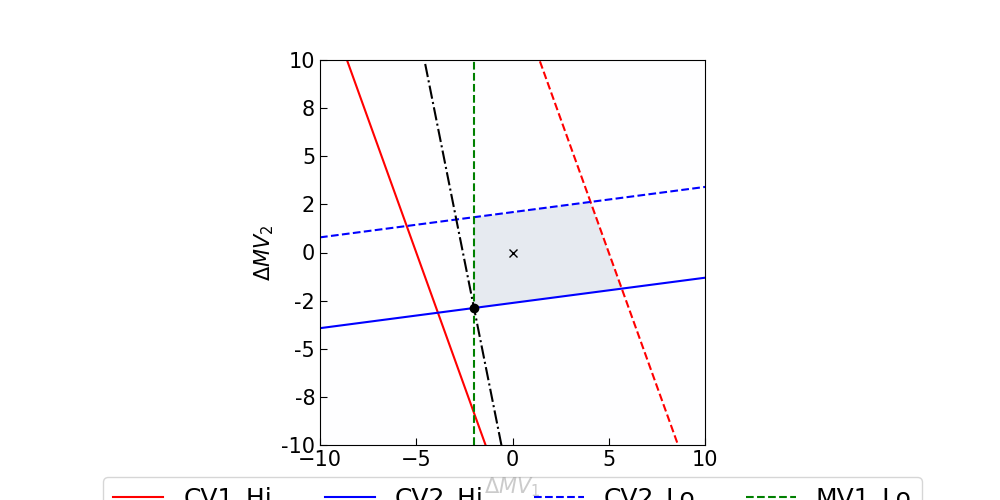

In [123]:
%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

lpc_MV1 = 1
lpc_MV2 = 0.2

MV1_lims = [-2.0, 10.0]
MV2_lims = [-10.0, 10.0]

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo
m1 = (x >= MV1_lims[0]) & (x <= MV1_lims[1])
m2 = (x >= MV2_lims[0]) & (x <= MV2_lims[1])

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

soln, V = run_pulp(lpc_MV1, lpc_MV2, MV1_Lo=MV1_lims[0])
# y_obj = (1/lpc_MV1)*V - (lpc_MV1/lpc_MV2)*d
y_obj = (1/lpc_MV2)*V - (lpc_MV1/lpc_MV2)*d

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4 & m1 & m2).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');

plt.plot(MV1_lims[0] * np.ones(d.shape), d, 'g--', label='MV1_Lo');
# plt.plot(MV1_lims[1] * np.ones(d.shape), d, 'g-', label='MV1_Hi');
# plt.plot(MV2_lims[0] * np.ones(d.shape), d, 'g--', label='MV2_Lo');
# plt.plot(MV2_lims[1] * np.ones(d.shape), d, 'g-', label='MV2_Hi');

plt.plot(0,0,'kx');
# the soln
plt.plot(soln[0], soln[1], 'ok');

# the obj func
plt.plot(d, y_obj, '-.k');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

---------------------------------

## Interactive LP solver

Now let's look at an interactive example, where the LP costs and CV limits can be moved around to see how the LP solution is formulated.

<IPython.core.display.Javascript object>


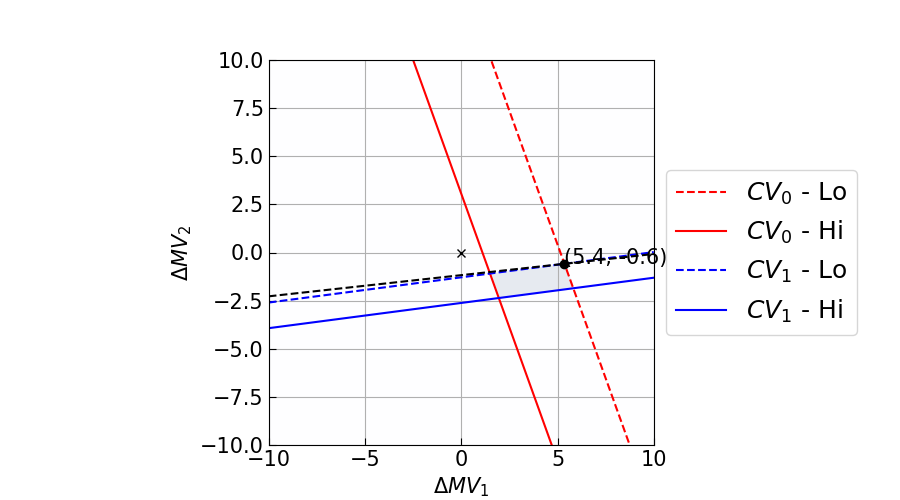

In [128]:
from ipywidgets.widgets.interaction import interact
import ipywidgets.widgets as widgets
from ipywidgets import Layout

%matplotlib notebook
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

values = [(CV1Lo, CV1Hi), (CV2Lo, CV2Hi)]
G = [(G11, G12), (G21, G22)]

sliders = [widgets.FloatRangeSlider(
                value=[CV1Lo, CV1Hi], min=-1.5, max=1.5, step=0.01,
                description='CV1 Limits',
                layout=Layout(width='80%', height='60px')),
            widgets.FloatRangeSlider(
                value=[CV2Lo, CV2Hi], min=-3, max=3.5, step=0.01,
                description='CV2 Limits',
                layout=Layout(width='80%', height='60px')),
            widgets.FloatSlider(
                value=cost_MV1, min=-2, max=2, step=0.01,
                description='MV1 Cost',
                layout=Layout(width='50%', height='50px')),
            widgets.FloatSlider(
                value=cost_MV2, min=-2, max=2, step=0.01,
                description='MV2 Cost',
                layout=Layout(width='50%', height='50px'))]


fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.grid(True, which='both')
plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.plot(0,0,'kx');
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
im = plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);

nCVs = 2 # How many CV lines?
CV_lines_lo = []
CV_lines_hi = []

colors = ['r', 'b', 'y']
for i in range(nCVs):
    y_lo = (values[i][0] - G[i][0]*d)/G[i][1]
    y_hi = (values[i][1] - G[i][0]*d)/G[i][1]    
    line_lo, = ax.plot(d, y_lo, f'--{colors[i]}', label=f'$CV_{i}$ - Lo');
    line_hi, = ax.plot(d, y_hi, f'-{colors[i]}', label=f'$CV_{i}$ - Hi');
    CV_lines_lo.append(line_lo)
    CV_lines_hi.append(line_hi)

soln_marker, = ax.plot([0], [0], 'ok')
soln_text = ax.text(0, 0, f'(0,0)')

obj_func, = ax.plot([], [], '--k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.relim()
ax.autoscale_view()

# Solve the LP
def run_lp(values):
    prob = LpProblem("DMC_problem",LpMinimize)
    MV1=LpVariable("MV1",-limits)
    MV2=LpVariable("MV2",-limits)
    prob += values[2]*MV1 + values[3]*MV2, "Cost function of MVs"
    
    # constraint formulation in terms of MV1 and MV2
    prob += G11*MV1+G12*MV2 <= values[0][1], "CV1 High Limit"
    prob += G11*MV1+G12*MV2 >= values[0][0], "CV1 Low Limit"
    prob += G21*MV1+G22*MV2 <= values[1][1], "CV2 High Limit"
    prob += G21*MV1+G22*MV2 >= values[1][0], "CV2 Low Limit"
    if (prob.solve(PULP_CBC_CMD(msg=0)) == 1):
        return [v.varValue for v in prob.variables()], value(prob.objective)
    else:
        print("NOT SOLVED - Infeasibility!")
        return [0,0], 0

def handle_slider_change(change):
    ## grab slider values for CV contraints
    values = [slider.value for slider in sliders]
    cost_MV1 = values[2]
    cost_MV2 = values[3]
    
    # Update CV constraint lines
    for i in range(nCVs):
        y_lo = (values[i][0] - G[i][0]*d)/G[i][1]
        y_hi = (values[i][1] - G[i][0]*d)/G[i][1]
        CV_lines_lo[i].set_data(d, y_lo)
        CV_lines_hi[i].set_data(d, y_hi)
    
    # Recalculate shaded regions
    c1 = G11*x+G12*y <= values[0][1]
    c2 = G11*x+G12*y >= values[0][0]
    c3 = G21*x+G22*y <= values[1][1]
    c4 = G21*x+G22*y >= values[1][0]

    # Shade the right regions
    im.set_data((c1 & c2 & c3 & c4).astype(float))
    
    # Find the LP soln
    soln, V = run_lp(values)
    y_obj = (1/cost_MV2)*V - (cost_MV1/cost_MV2)*d
    
    def get_sign(x):
        return ['-' if x < 0 else ('-' if x > 0 else '')]

    # the soln
    soln_marker.set_data(soln[0], soln[1]);
    soln_text.set_position((soln[0], soln[1]));
    soln_text.set_text("({:.1f}, {:.1f})".format(soln[0], soln[1]))
    obj_func.set_data(d, y_obj);
        
    fig.canvas.draw()
#     fig.canvas.flush_events()
    
# register slides
for widget in sliders:
    widget.observe(handle_slider_change, names='value')

widgets.VBox(sliders)